In [76]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from pathlib import Path
import numpy as np
from collections import defaultdict
from itertools import product

In [50]:
DATA=Path('/Users/jonniebarnsley/data/karthaus24/group11-project')
iso = 'isochrones.nc'
variable = DATA / 'ncfiles/variable-seasonality.nc'
fixed = DATA / 'ncfiles/fixed-seasonality.nc'

In [51]:
basin_path = 'greenland_drainages.nc'
basinnc = xr.open_dataset(basin_path)
basinnc

<xarray.Dataset>
Dimensions:   (y1: 270, x1: 330)
Coordinates:
  * x1        (x1) float32 -75.9 -75.7 -75.5 -75.3 ... -10.7 -10.5 -10.3 -10.1
  * y1        (y1) float32 58.05 58.15 58.25 58.35 ... 84.65 84.75 84.85 84.95
Data variables:
    drainage  (y1, x1) float64 ...
Attributes:
    title:       ice sheet-shelf
    horiz_grid:  regular
    projection:  latlon
    history:     Tue May 28 16:27:55 2024: ncks -O drainagemask.nc -v drainag...
    NCO:         netCDF Operators version 5.0.3 (Homepage = http://nco.sf.net...

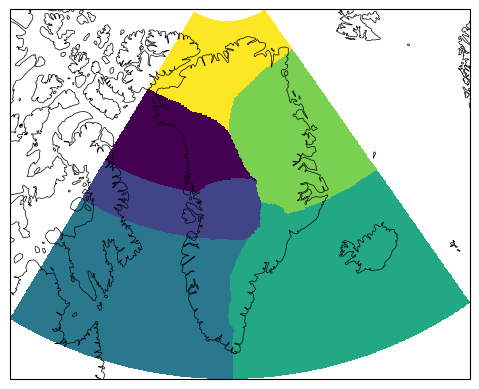

In [56]:
drainage = basinnc.drainage
x = basinnc.x1
y = basinnc.y1

fig = plt.figure()
ax = plt.axes(projection = ccrs.NorthPolarStereo(central_longitude=315))

ax.pcolormesh(x, y, drainage, transform=ccrs.PlateCarree())
ax.coastlines(lw=0.5)

In [57]:
model = xr.open_dataset(fixed)
model

<xarray.Dataset>
Dimensions:      (x1: 330, y1: 270, x0: 330, y0: 270, z: 12, time: 240)
Coordinates:
  * x1           (x1) float32 -75.9 -75.7 -75.5 -75.3 ... -10.5 -10.3 -10.1
  * y1           (y1) float32 58.05 58.15 58.25 58.35 ... 84.75 84.85 84.95
  * x0           (x0) float32 -75.8 -75.6 -75.4 -75.2 ... -10.4 -10.2 -10.0
  * y0           (y0) float32 58.1 58.2 58.3 58.4 58.5 ... 84.7 84.8 84.9 85.0
  * z            (z) float32 0.0 0.025 0.1 0.225 0.375 ... 0.925 0.965 0.99 1.0
  * time         (time) float32 -2e+04 -1.99e+04 -1.98e+04 ... -200.0 -100.0 0.0
Data variables: (12/53)
    vershis      (time) float32 ...
    sealev       (time) float32 ...
    toti         (time) float32 ...
    totig        (time) float32 ...
    totif        (time) float32 ...
    tota         (time) float32 ...
    ...           ...
    ubot         (time, y1, x0) float32 ...
    ua           (time, y1, x0) float32 ...
    vtop         (time, y0, x1) float32 ...
    vbot         (time, y0, x1) float32 ...
    va           (time, y0, x1) float32 ...
    msector      (time, y1, x1) float32 ...
Attributes:
    title:                     ice sheet-shelf
    horiz_grid:                regular
    projection:                latlon
    history:                   Thu May 10 19:00:24 2018: ncrcat -l . keisling...
    NCO:                       "4.6.0"
    nco_openmp_thread_number:  1

In [147]:
model = xr.open_dataset(fixed)
area = model.darea
fixed_timeseries = defaultdict(list)
years = np.arange(-14000, -6900, 100)
for time in years:
    for basin in range(1, 7):
        mask = drainage == basin
        
        timeslice = model.sel(time=time)
        height = timeslice.h

        # mask out iceland and ellesmere island not including in isochrone data
        height = height.where(((height.x1 > - 60) | (height.y1 > 73)))
        height = height.where(((height.x1 < - 25) | (height.y1 > 67)))

        # select basin area
        basin_height = height.where(mask)

        extent = xr.where(basin_height > 0, 1, 0)
        total = float(np.sum(extent * area))
        fixed_timeseries[basin].append(total)

In [148]:
model = xr.open_dataset(variable)
area = model.darea
variable_timeseries = defaultdict(list)
years = np.arange(-14000, -6900, 100)
for time in years:
    for basin in range(1, 7):
        mask = drainage == basin
        
        timeslice = model.sel(time=time)
        height = timeslice.h

        # mask out iceland and ellesmere island not including in isochrone data
        height = height.where(((height.x1 > - 60) | (height.y1 > 73)))
        height = height.where(((height.x1 < - 25) | (height.y1 > 67)))

        # select basin area
        basin_height = height.where(mask)

        extent = xr.where(basin_height > 0, 1, 0)
        total = float(np.sum(extent * area))
        variable_timeseries[basin].append(total)

In [143]:
basin_dic = {
    1: 'Northwest',
    2: 'Central West',
    3: 'Southwest',
    4: 'Southeast',
    5: 'Northeast',
    6: 'North'
}

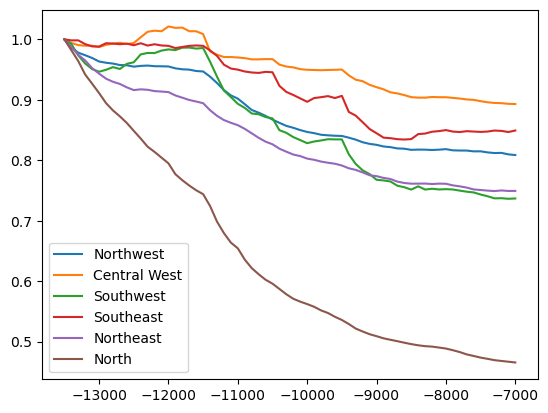

In [144]:
fig = plt.figure()
ax = plt.axes()

for basin in range(1, 7):
    ax.plot(years, np.array(variable_timeseries[basin])/variable_timeseries[basin][0], label=basin_dic[basin])
ax.legend()

In [145]:
iso_area_by_basin = {
    'North': [0, 6, 8, 11, 15, 20, 26, 29, 34, 37, 39, 42, 43],
    'Northwest': [0, 10, 13, 17, 19, 20, 22, 23, 25, 25, 25, 25, 25],
    'Central West': [0, 9, 14, 17, 20, 23, 26, 27, 28, 28.4, 28.8, 29, 29],
    'Southwest': [0, 8, 13, 18, 24, 32, 36, 37, 38, 39, 39, 40, 41],
    'Southeast': [0, 10, 13, 14, 16, 17, 23, 25, 25, 25, 25, 25, 25],
    'Central East': [0, 7, 10, 12, 14, 18, 21, 25, 32, 38, 39, 39, 38],
    'Northeast': [0, 5, 8, 11, 15, 18, 26, 29, 34, 37, 39, 42, 43]
}

iso_area_by_basin['East'] = np.array(iso_area_by_basin['Southeast']) + np.array(iso_area_by_basin['Central East'])

iso_times = np.array([-13500, -12500, -11750, -11250, -10750, -10250, -9750, -9250, -8750, -8250, -7750, -7250, -6750])/1000
xerr = np.array([500, 500, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250, 250])/1000

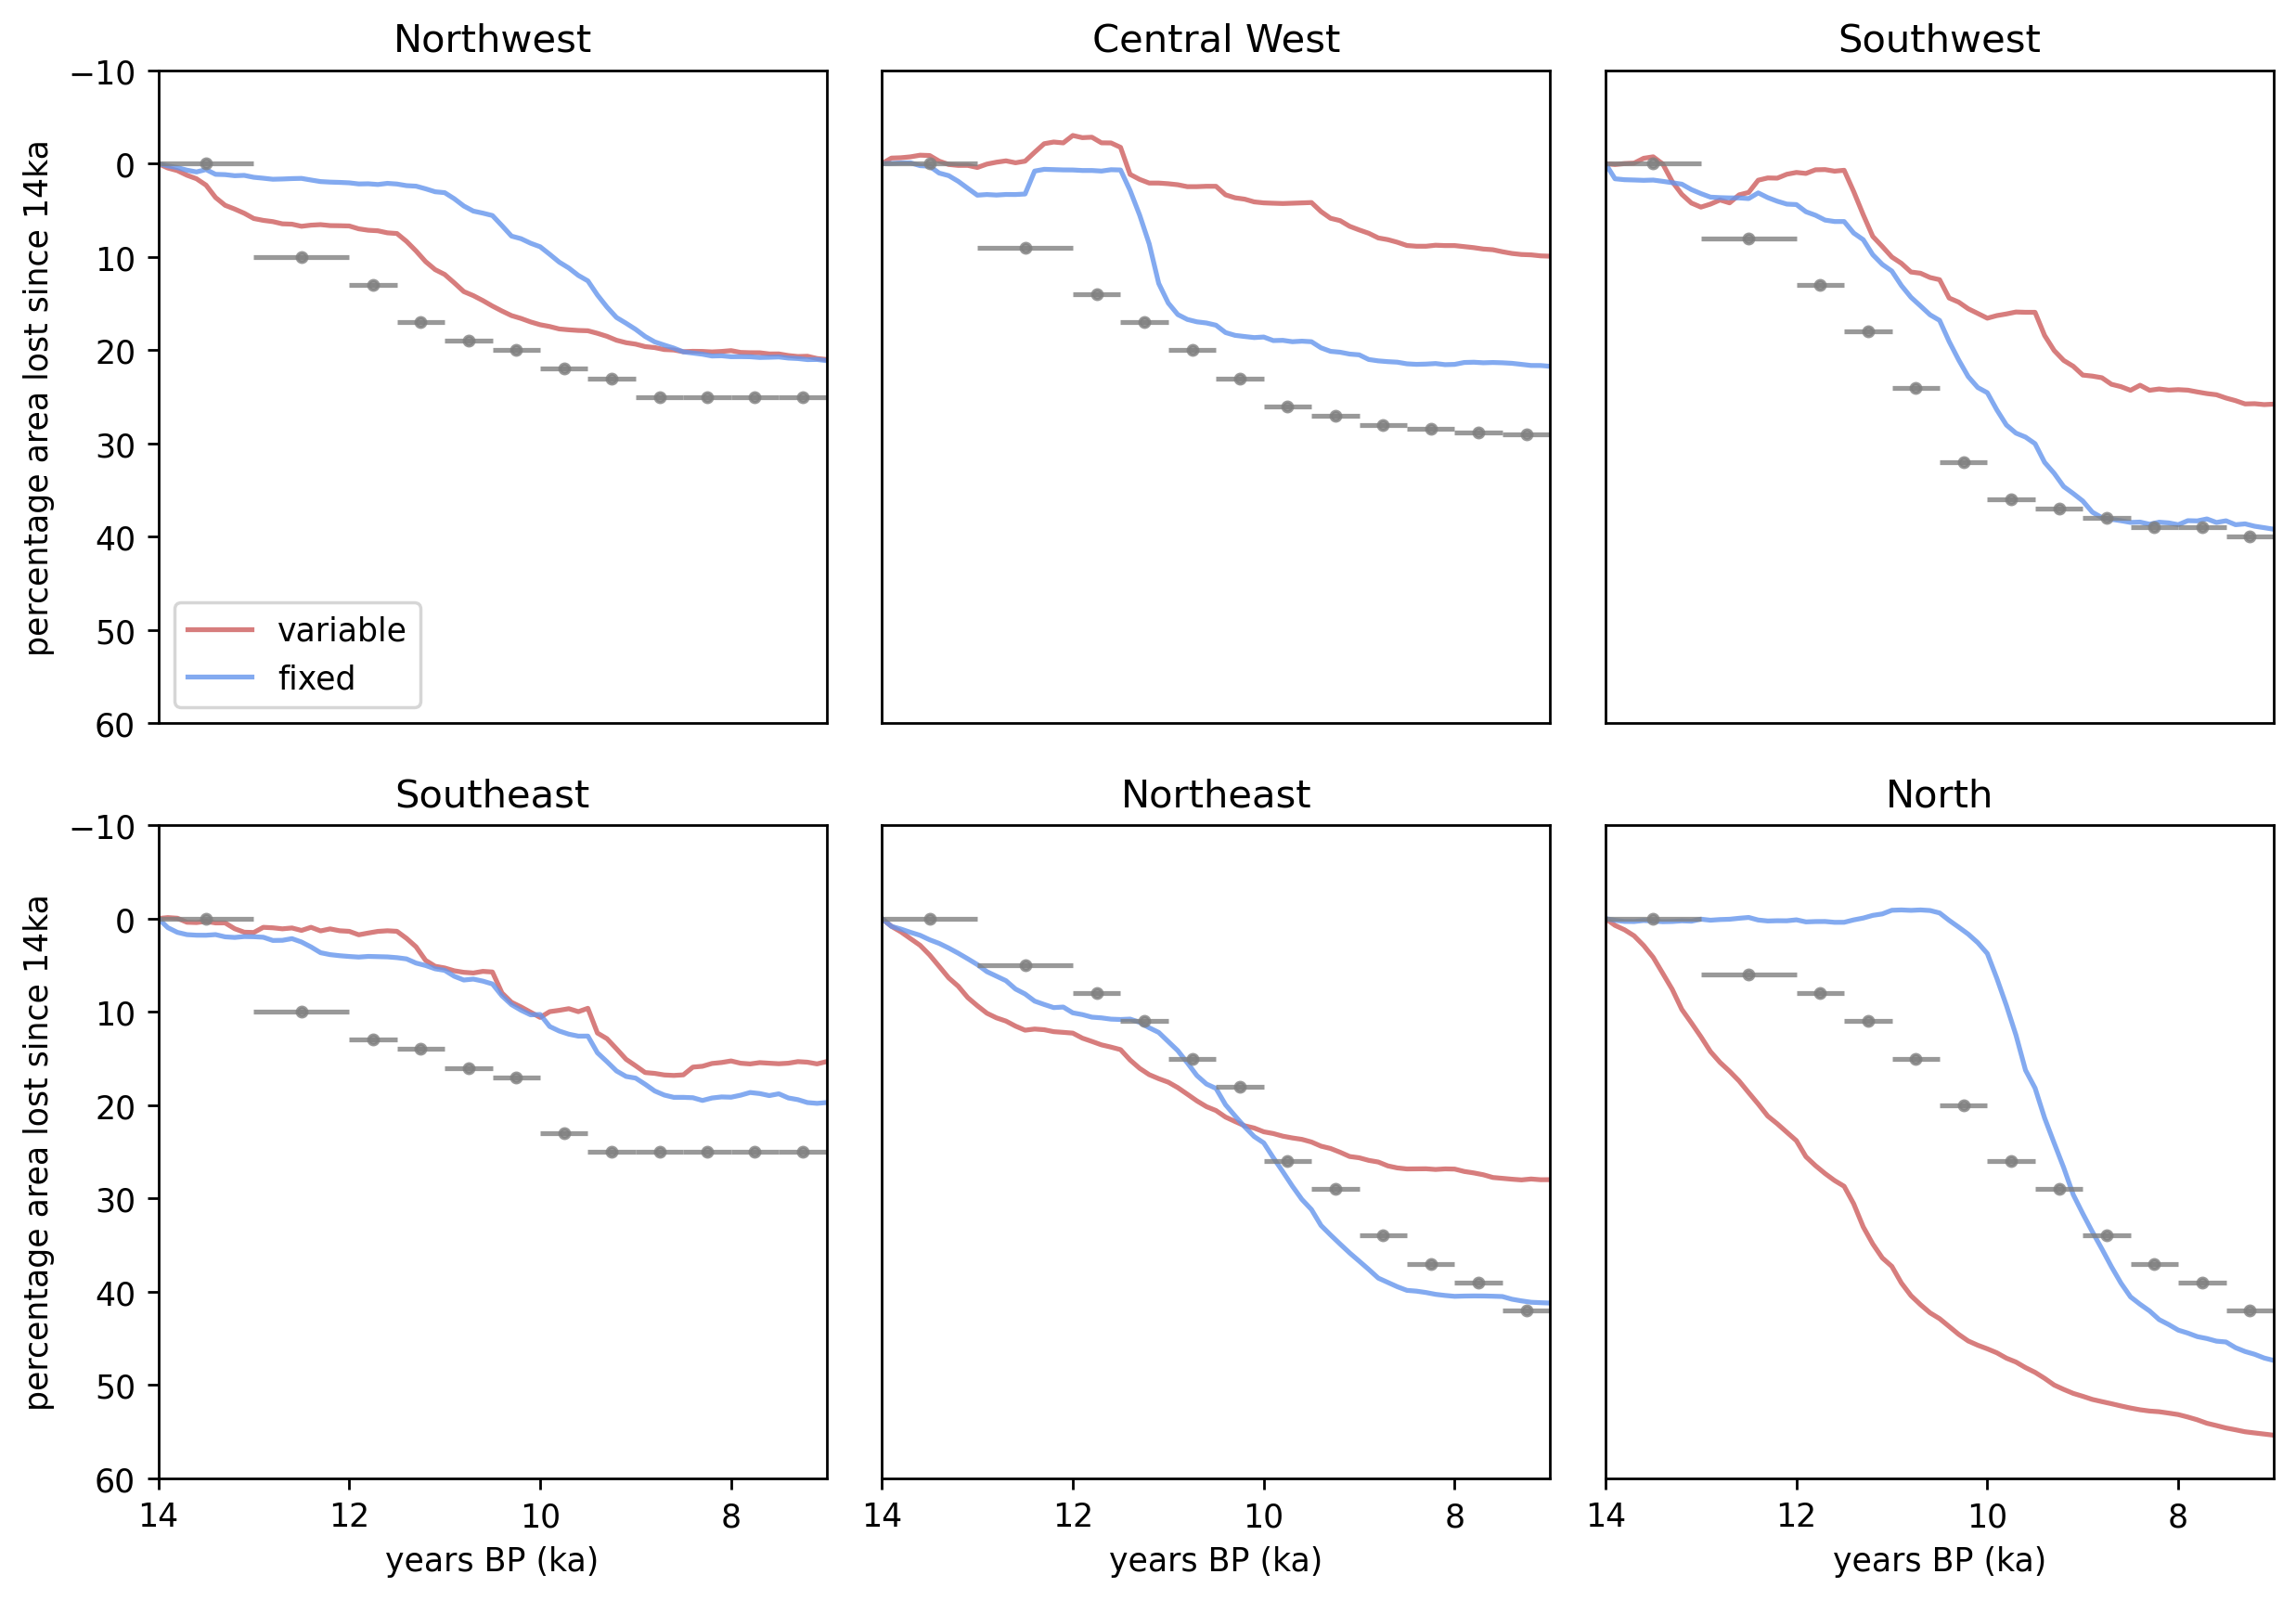

In [149]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 7), dpi=250)

for ax, basin in zip(axes.flatten(), range(1, 7)):

    ax.plot(-years/1000, (1-np.array(variable_timeseries[basin])/variable_timeseries[basin][0])*100, label='variable', color='indianred', alpha=0.8)
    ax.plot(-years/1000, (1-np.array(fixed_timeseries[basin])/fixed_timeseries[basin][0])*100, label='fixed', color='cornflowerblue', alpha=0.8)
    ax.set_title(basin_dic[basin])
    #ax.scatter(iso_times, iso_area_by_basin[basin_dic[basin]], color='grey', s=8, alpha=0.8)
    ax.errorbar(-iso_times, iso_area_by_basin[basin_dic[basin]], xerr=xerr, fmt="o", alpha=0.8, ecolor='grey', color='grey', ms=3)
    ax.set_ylim([60, -10])
    ax.set_xlim([14, 7])
    #ax.invert_yaxis()
    #ax.grid(alpha=0.5)

axes[0][0].legend(loc='lower left')

for i, j in product(range(2), range(3)):
    if i<1:
        axes[i][j].set_xticks([])
    else:
        axes[i][j].set_xlabel('years BP (ka)')
    if j>0:
        axes[i][j].set_yticks([])
    else:
        axes[i][j].set_ylabel('percentage area lost since 14ka')

fig.tight_layout()
plt.savefig('plots/basins_timeseries.png', format='png')

13